In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch.nn as nn
import torch
import itertools

from emnist import get_emnist_data_loaders
from models.crnn.crnn import CRNN
from models.lstm_cnn.lstm_cnn import CNN_LSTM
from training.trainer import Trainer
from hyperparameter import common_hyperparameters, model_specific_hyperparameters
from evaluation.loss import plot_loss
from evaluation.evaluations_utils import create_directory_if_not_exists
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, LambdaLR, CyclicLR

In [17]:
# Generate all possible combinations of hyperparameters
param_combinations = list(itertools.product(*model_specific_hyperparameters.values()))
print(f"Number of Hyperparameter combinations: {len(param_combinations)}")

Number of Hyperparameter combinations: 9


In [18]:
trainers = {}
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    print(f"Testing parameters: \n"
          f"GRU Hidden Size: {gru_hidden_size}, \n"
          f"GRU Num Layers: {gru_num_layers}, \n"
          f"CNN Output Height: {cnn_output_height}, \n"
          f"CNN Output Width: {cnn_output_width}, \n"
          f"Learning Rate: {learning_rate}, \n"
          f"Batch Size: {batch_size}, \n"
          f"Validation Batch Size: {batch_size_val} \n")

    num_classes = common_hyperparameters["NUM_CLASSES"]   
    blank_label = common_hyperparameters["BLANK_LABEL"]
    image_height = common_hyperparameters["IMAGE_HEIGHT"]
    digits_per_sequence = common_hyperparameters["DIGITS_PER_SEQUENCE"]
    number_of_sequences = common_hyperparameters["NUMBER_OF_SEQUENCES"]
    epochs = common_hyperparameters["EPOCHS"]
    weight_decay = common_hyperparameters["WEIGHT_DECAY"]

    # Load data
    train_loader, val_loader, test_loader = get_emnist_data_loaders(number_of_sequences, digits_per_sequence, batch_size, batch_size_val)


    # Setup model
    models = {
        "lstm_cnn": CNN_LSTM(gru_hidden_size=gru_hidden_size, gru_num_layers=gru_num_layers, num_classes=num_classes, cnn_output_height=cnn_output_height),
        "crnn": CRNN(gru_hidden_size, gru_num_layers, num_classes, cnn_output_height)
    }

    criteria = {
        "crnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True),
        "lstm_cnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True)
    }

    optimizer_configs = {
        "adam": torch.optim.Adam,
        # "adam_w": torch.optim.AdamW,
        "adam_w_regulise": torch.optim.AdamW
    }

    scheduler_configs = {
        "step_lr": (StepLR, {"step_size": 5, "gamma": 0.5}),
        # "multi_step_lr": (MultiStepLR, {"milestones": [5, 10, 15], "gamma": 0.5}),
        "exponential_lr": (ExponentialLR, {"gamma": 0.95}),
        # "cosine_annealing_lr": (CosineAnnealingLR, {"T_max": 10}),
        # "lambda_lr": (LambdaLR, {"lr_lambda": lambda epoch: 0.95 ** epoch}),
        # "cyclic_lr": (CyclicLR, {"base_lr": 0.001, "max_lr": 0.1})
    }

    # Setup trainer
    # lstm_trainer =  Trainer(models["lstm_cnn"], criterions["lstm_cnn"], optimizers["lstm_cnn"], train_loader, val_loader, test_loader, epochs=epochs, args={
    #         "blank_label": blank_label,
    #         "cnn_output_width": cnn_output_width,
    #     })
    # trainers = {
    #     "lstm_cnn": lstm_trainer
    # }

    for model_name, model in models.items():
        for optimizer_name, optimizer_class in optimizer_configs.items():
            if optimizer_name == "adam_w_regulise":
                optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            else:
                optimizer = optimizer_class(model.parameters(), lr=learning_rate)
            for scheduler_name, (scheduler_class, scheduler_args) in scheduler_configs.items():
                scheduler = scheduler_class(optimizer, **scheduler_args)
                criterion = criteria[model_name]
                trainer_name = f"{model_name}-{optimizer_name}_{scheduler_name}_trainer"
                trainer = Trainer(
                    model, model_name, criterion, optimizer, train_loader, val_loader, test_loader,
                    epochs=epochs, args={"blank_label": blank_label, "cnn_output_width": cnn_output_width},
                )
                trainers[trainer_name] = trainer
            break
        break
    break
print(f"Prepared {len(trainers)} models for training.")

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.01, 
Batch Size: 32, 
Validation Batch Size: 1 

Prepared 2 models for training.


In [19]:
 metrics_global = {}
for model_name, trainer in trainers.items():
    print(f"Training {model_name}")
    metrics = trainer.train_validate_test()
    metrics_global[model_name] = metrics
    print(f"Finished training {model_name}")

    # Save the trained model with abbreviation and parameter values
    abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
    abbreviation = abbreviation.replace(".", "_")
    main_model_name = model_name.split('-', 1)[0]
    base_path = f'models/{main_model_name}/{model_name}/{model_name}_{abbreviation}/'
    create_directory_if_not_exists(base_path)
    save_path = base_path + "model.pth"
    
    torch.save(trainer.model.state_dict(), save_path)

Training lstm_cnn-adam_step_lr_trainer
100%|██████████| 22/22 [00:03<00:00,  6.50it/s]
EPOCH 1/2 - TRAINING. Correct: 0/700 = 0.0000 - Average CER Score: 0.996
100%|██████████| 299/299 [00:01<00:00, 271.66it/s]
EPOCH 1/2 - VALIDATING. Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 22/22 [00:03<00:00,  6.56it/s]
EPOCH 2/2 - TRAINING. Correct: 0/700 = 0.0000 - Average CER Score: 0.998
100%|██████████| 299/299 [00:01<00:00, 268.10it/s]
EPOCH 2/2 - VALIDATING. Correct: 0/299 = 0.0000 - Average CER Score: 1.0
Finished training lstm_cnn-adam_step_lr_trainer
Training lstm_cnn-adam_exponential_lr_trainer
100%|██████████| 22/22 [00:03<00:00,  6.51it/s]
EPOCH 1/2 - TRAINING. Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████| 299/299 [00:01<00:00, 266.89it/s]
EPOCH 1/2 - VALIDATING. Correct: 0/299 = 0.0000 - Average CER Score: 1.0
100%|██████████| 22/22 [00:03<00:00,  6.52it/s]
EPOCH 2/2 - TRAINING. Correct: 0/700 = 0.0000 - Average CER Score: 1.0
100%|██████████

In [20]:
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    print(f"Plotting loss for parameters: \n"
          f"GRU Hidden Size: {gru_hidden_size}, \n"
          f"GRU Num Layers: {gru_num_layers}, \n"
          f"CNN Output Height: {cnn_output_height}, \n"
          f"CNN Output Width: {cnn_output_width}, \n"
          f"Learning Rate: {learning_rate}, \n"
          f"Batch Size: {batch_size}, \n"
          f"Validation Batch Size: {batch_size_val} \n")

    for model_name, trainer in trainers.items():
        # Load model
        abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
        abbreviation = abbreviation.replace(".", "_")
        main_model_name = model_name.split('-', 1)[0]
        base_path = f'models/{main_model_name}/{model_name}/{model_name}_{abbreviation}/'
        model_path = base_path + "model.pth"
        
        model = model.to("cpu")
        model.load_state_dict(torch.load(model_path))

        # Plot the trained model
        plot_loss(model_name=model_name, train_loss_per_epoch=trainer.epoch_train_cers, val_loss_per_epoch=trainer.epoch_val_cers, figure_evaluation_dir=base_path)
    break

Plotting loss for parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.01, 
Batch Size: 32, 
Validation Batch Size: 1 

models/lstm_cnn/lstm_cnn-adam_step_lr_trainer/lstm_cnn-adam_step_lr_trainer_G128__L2__H4__W32__LR0_01__BS32__BSV1/lstm_cnn-adam_step_lr_trainer_loss.png
models/lstm_cnn/lstm_cnn-adam_exponential_lr_trainer/lstm_cnn-adam_exponential_lr_trainer_G128__L2__H4__W32__LR0_01__BS32__BSV1/lstm_cnn-adam_exponential_lr_trainer_loss.png


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Plotting loss for parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.01, 
Batch Size: 32, 
Validation Batch Size: 1 

100%|██████████| 1/1 [00:00<00:00, 207.21it/s]
TESTING. Correct: 0/1 = 0.0000 - Average CER Score: 1.0


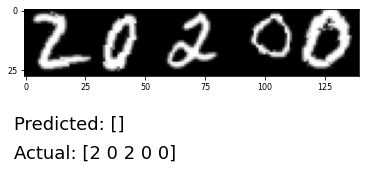

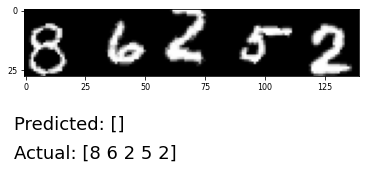

100%|██████████| 1/1 [00:00<00:00, 127.52it/s]
TESTING. Correct: 0/1 = 0.0000 - Average CER Score: 1.0


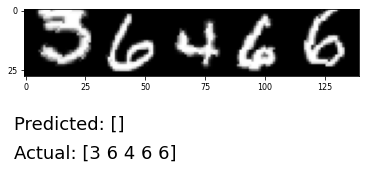

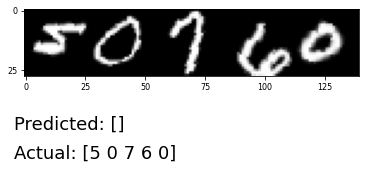

In [22]:
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    print(f"Plotting loss for parameters: \n"
          f"GRU Hidden Size: {gru_hidden_size}, \n"
          f"GRU Num Layers: {gru_num_layers}, \n"
          f"CNN Output Height: {cnn_output_height}, \n"
          f"CNN Output Width: {cnn_output_width}, \n"
          f"Learning Rate: {learning_rate}, \n"
          f"Batch Size: {batch_size}, \n"
          f"Validation Batch Size: {batch_size_val} \n")

    for model_name, trainer in trainers.items():
        # Load model
        abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
        abbreviation = abbreviation.replace(".", "_")
        main_model_name = model_name.split('-', 1)[0]
        base_path = f'models/{main_model_name}/{model_name}/{model_name}_{abbreviation}/'
        model_path = base_path + "model.pth"

        # Plot the trained model
        trainer.test(plot_n=2)
    break